In [1]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import pandas as pd
from matplotlib.animation import FuncAnimation
import geopandas as gpd
import threedigrid
from threedigrid.admin.gridresultadmin import GridH5ResultAdmin
from threedigrid.admin.gridadmin import GridH5Admin

import uuid

In [2]:
from __my_functions_flooddepth_houses import get_time_dimensions_flood
from __my_functions_flooddepth_houses import create_df_flooddepth_houses

### paths

In [3]:
## flood results paths
# floodresults_path = '/Users/louiseklingen/Documents/TU/modelresults/modelresults_denhelder' 
floodresults_path = 'E:/projecten/P2019_1_DenHelderOverstroming/data_en_modellen/modelresults' 

In [4]:
general_path = 'E:\paper2_analysis/depth_arrival_zones'
figures_path = f'{general_path}/figures'
input_path = f'{general_path}/input'
output_path = f'{general_path}/output'

-----------------------

### load flood results

In [5]:
## flood scenario 
scenario_name = 'scen1_voorpiek'
simulation_name = 'lk_dh_test13_5verloop_2d'
## start_breach_time = '2000-01-01T18:00:00'
start_breach_time = '2000-01-01T00:00:00'

In [6]:
## flood result files
netcdf_file = (f'{floodresults_path}/{simulation_name}/results_3di.nc')
gridadmin_file = (f'{floodresults_path}/{simulation_name}/gridadmin.h5')
gr = GridH5ResultAdmin(gridadmin_file , netcdf_file)
ga = GridH5Admin(gridadmin_file)

In [7]:
time_humanized, last_timestamp  = get_time_dimensions_flood(gr, start_breach_time)

rekentijd: 48.00278541015558 uur
aantal tijdstappen: 577
interval: 300.05, secondes = 5.0 min
 breach start time at: 2000-01-01 00:00:00


----------------

## load buurten and houses in area

In [28]:
buurten_scen2_test = gpd.read_file(f'{input_path}/buurten_scen2_test.shp')
# buurten_scen2_test.head(1)

In [10]:
houses_all = gpd.read_file(f'{input_path}/huizen_centroid_flood_area_cleaned.shp')

------------------------------------------------------------

### select one random zone for testing

In [154]:
random_index = 16
selected_zone = buurten_scen2_test.iloc[random_index]
selected_zone_geom = selected_zone.geometry
# selected_zone_geom

### view zones for testing

In [173]:
selected_zones = buurten_scen2_test.iloc[:5]

nr houses in Marinehaven: 303
too many, therefor sample of 40 houses taken
nr houses in Oostsloot: 989
too many, therefor sample of 40 houses taken
nr houses in Centrum: 610
too many, therefor sample of 40 houses taken
nr houses in Willemsoord: 244
too many, therefor sample of 40 houses taken
nr houses in Sluisdijk: 531
too many, therefor sample of 40 houses taken


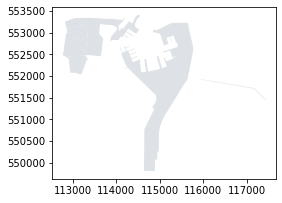

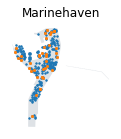

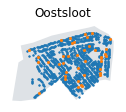

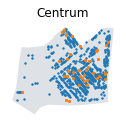

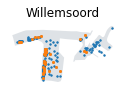

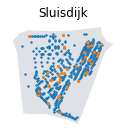

In [172]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)

for index, row in selected_zones.iterrows():
    gpd.GeoSeries(row.geometry).plot(ax=ax, color="#dee2e6")
    
    #create sample for all seleced zones
    sample_houses_witinZone = create_sample_houses_witinZone(samplesize, houses_all, row )
#     create_sample_houses_witinZone(samplesize, houses_all, selected_zone )

### sample houses when set is too large

nr houses in Tuindorp-Oost: 550
too many, therefor sample of 40 houses taken


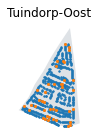

###  calculate flood depth in these zones

In [36]:
flooddepth_time_houses_df = create_df_flooddepth_houses(scenario_name, 
                            samplesize, sample_uuid, 
                            houses_df, gr, 
                            time_humanized, last_timestamp, 
                            output_path)


(10957.0, 10957.138923611112)

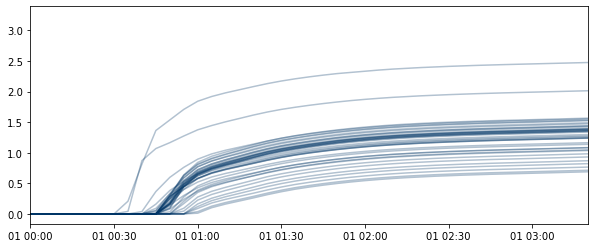

In [137]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)

for label, content in flooddepth_time_houses_df.items():
    ax.plot(content, c = '#003566', alpha = 0.3)

ax.set_xlim(time_humanized[0],time_humanized[40])
plt.grid()

In [ ]:
#### PER ZONE:
#- aankomstijd 
# - max flood diepte

In [127]:
def calculate_first_qth_arrival_and_maxdepth(flooddepth_time_houses_df):
    arrival_times = []
    max_depths = []
    quantile_value = 0.1
    
    #loop over all (sample) houses within zone
    for label, content in flooddepth_time_houses_df.items():
        max_depth = content.max()
        max_depths.append(max_depth)

        for i in range(len(content)):
            if content[i] > 0.01:
                arrival_time = flooddepth_time_houses_df.index[i]
                arrival_timestamp = datetime.timestamp(arrival_time)
                arrival_times.append(arrival_timestamp)
                break

    #derive arrival for zone
    first_qth_arrival = np.quantile(arrival_times, quantile_value)
    first_qth_arrival_dt = datetime.fromtimestamp(first_qth_arrival)
    
    #derive max depth for zone
    max_depths_qth = np.quantile(max_depths, quantile_value)
    
    
    return first_qth_arrival_dt, max_depths_qth 


first_qth_arrival, max_depths_qth  = calculate_first_qth_arrival_and_maxdepth(flooddepth_time_houses_df)
first_qth_arrival, max_depths_qth 

(datetime.datetime(2000, 1, 1, 0, 45, 3), 1.6777022709478961)

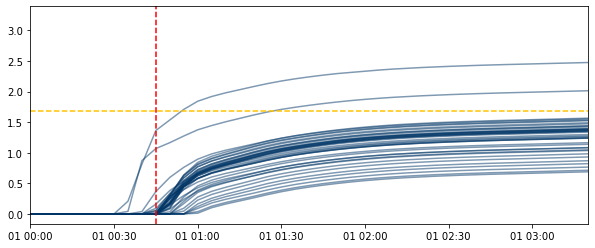

In [133]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)

for label, content in flooddepth_time_houses_df.items():
    ax.plot(content, c = '#003566', alpha = 0.5)

ax.set_xlim(time_humanized[0],time_humanized[40])
ax.axvline(x = first_qth_arrival, color = 'r', linestyle ='--')
ax.axhline(max_depths_qth, color= '#ffc300', linestyle ='--')
# ax.set_ylim(-1,1)
# plt.grid()